# Utils

## Download Libraries

In [ ]:
!pip install redditcleaner
!pip install contractions
!pip install --upgrade openai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 12.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 17.4 MB/s eta 0:00:00


## Imports

In [ ]:
import pandas as pd
import json
import random
import re
import numpy as np
import redditcleaner
import gc
import contractions
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split

## Environment Variables

In [ ]:
# General parameters
CLASSES = ['INTJ', 'INTP', 'INFJ', 'INFP',
           'ENFP', 'ENTJ', 'ENFJ', 'ENTP',
           'ESFP', 'ESTJ', 'ESFJ', 'ESTP',
           'ISTP', 'ISFP', 'ISFJ', 'ISTJ']

# Filepaths
FILEPATH_TRAIN = '/content/data_train.jsonl'
SHUFFLED_FILEPATH_TRAIN = '/content/shuffled_data_train.jsonl'
FILEPATH_DF_TRAIN = '/content/mbti_train.csv'
FILEPATH_DF_TEST = '/content/mbti_test.csv'
FILEPATH_DF_TRAIN_WITH_INDEX = '/content/mbti_train_withIndex.csv'
FILEPATH_DF_TEST_WITH_INDEX = '/content/mbti_test_withIndex.csv'
FILEPATH_DF_EXTRA_TEST = '/content/mbti_extra_test.csv'
FILEPATH_DF_EXTRA_TEST_WITH_INDEX = '/content/mbti_extra_test_withIndex.csv'
Y_PRED_FILEPATH = '/content/j2-grande_y_pred.npy'
Y_TRUE_FILEPATH = '/content/j2-grande_y_true.npy'

# Training variables
TEST_SIZE = 0.15
TRAIN_SIZE = 0.85
TAKE_SAMPLES = 1200
PREFIX = 'based on MBTI classify the following text:\n\n'
SUFFIX = '\n\nMBTI classification:'
PROMPT_LEN = 22800 # 2047 tokens is approximately 6000 characters ===> 2047 * 4 = 8188 tokens is approximately 6000 * 4 = 22800 characters

# Data Preprocessing

## Download Dataset

In [ ]:
%%capture
!pip install -U --no-cache-dir gdown --pre
!gdown --id 1q-6j41B1-ouCmGl9VUyctdWN_PUg4zfn

## Load Dataset

In [ ]:
data = pd.read_csv('/content/mbti_1.csv')
gc.collect()

8

## Visualization of the dataset

In [ ]:
data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [ ]:
data['type'].value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

## Clean the data

In [ ]:
def clean_text(data):
    data_length = []
    cleaned_text = []

    for sentence in tqdm(data.posts):
        sentence = redditcleaner.clean(sentence)
        
        sentence = re.sub(r'\[.*?\]', '', sentence)
        sentence = re.sub(r'\{.*?\}', '', sentence)
        sentence = re.sub(r'<.*?>+', '', sentence)
        sentence = re.sub(r'\n', ' ', sentence)
        sentence = re.sub(r'\\\/r\\\/', '', sentence)
        sentence = re.sub(r'/r/', '', sentence)
      
        sentence = re.sub(r'https?://[^\s<>"]+|www\.[^\s<>"]+', ' ',sentence)
        sentence = re.sub(r'\(?(https?|http?)://\S+|www\.\S+\)?', ' ', sentence)
        sentence = re.sub(r'(https?|http?)://\S+|www\.\S+', ' ', sentence)
        sentence = re.sub(r'(https?|http?)://[^\s<>"]+|www\.[^\s<>"]+', ' ',sentence)
        
        sentence = sentence.lower()
        sentence = contractions.fix(sentence) # expand contraction (I'm ==> I am)
        sentence = re.sub('[^0-9a-z]', ' ',sentence)

        sentence = re.sub(r"\s+", ' ', sentence) # Replace duplicated whitespaces with a single whitespace
        sentence = sentence.lstrip() # Remove whitespaces from the start of the sentence
        sentence = sentence.rstrip() # Remove whitespaces from the end of the sentence

        data_length.append(len(sentence.split()))
        cleaned_text.append(sentence)

    return cleaned_text

In [ ]:
data.posts = clean_text(data)
data

  0%|          | 0/8675 [00:00<?, ?it/s]

,type,posts
0,INFJ,enfp and intj moments sportscenter not top ten...
1,ENTP,i am finding the lack of me in these posts ver...
2,INTP,good one of course to which i say i know that ...
3,INTJ,dear intp i enjoyed our conversation the other...
4,ENTJ,you are fired that is another silly misconcept...
...,...,...
8670,ISFP,ixfp just because i always think of cats as fi...
8671,ENFP,so if this thread already exists someplace els...
8672,INTP,so many questions when i do these things i wou...
8673,INFP,i am very conflicted right now when it comes t...


## Split to train and test
85% train, 15% test

In [ ]:
# Split dataset
train_data, test_data = train_test_split(data, random_state=0, test_size=TEST_SIZE)

train_size = len(train_data)
test_size = len(test_data)
train_size, test_size

(7373, 1302)

## Save the data
Save the split to a csv file.

the data is splitted randomly this it must be saved in case session crushes.

In [ ]:
# Save train set with and without index
train_data.to_csv(FILEPATH_DF_TRAIN_WITH_INDEX, index=True, index_label='index')
train_data.to_csv(FILEPATH_DF_TRAIN, index=False)

# Save test set with and without index
test_data.to_csv(FILEPATH_DF_TEST_WITH_INDEX, index=True, index_label='index')
test_data.to_csv(FILEPATH_DF_TEST, index=False)

## Create JSONL file

In [ ]:
def write_jsonl_to_file(f, prompt, completion):
    # Create a dictionary for the current row
    row_dict = {'prompt': prompt, 'completion': completion}
    # Convert the dictionary to a JSON string
    row_json = json.dumps(row_dict)
    # Write the JSON string to the output file
    f.write(row_json + '\n')

In [ ]:
with open(FILEPATH_TRAIN, 'w', newline='') as f:
  for per_type in CLASSES:
    current_df = train_data[(train_data['type'] == per_type) & (train_data['posts'].str.len() < PROMPT_LEN)]
    for _, row in current_df.iloc[:TAKE_SAMPLES].iterrows():
      if row['posts'] and row['type']:
        write_jsonl_to_file(f, PREFIX + row['posts'] + SUFFIX, ' ' + row['type'].lower())

Save for testing the rows that is left and picked for training

In [ ]:
# initialize an empty dataframe to store the rows that we won't use for training in the train set
extra_test_data = pd.DataFrame(columns=train_data.columns)

for per_type in CLASSES:
  current_df = train_data[(train_data['type'] == per_type) & (train_data['posts'].str.len() < PROMPT_LEN)]
  for _, row in current_df.iloc[TAKE_SAMPLES:].iterrows():
    if row['posts'] and row['type']:
      extra_test_data = extra_test_data.append(row, ignore_index=False) # we will use index later

Save extra test smaples as csv file

In [ ]:
extra_test_data.to_csv(FILEPATH_DF_EXTRA_TEST_WITH_INDEX, index=True, index_label='index')
extra_test_data.to_csv(FILEPATH_DF_EXTRA_TEST, index=False)

## Shuffle the JSONL file

In [ ]:
def shuffle_jsonl_file(filepath, shuffle_filepath):
    # Read the file and shuffle the lines
    with open(filepath, 'r') as f:
        lines = f.readlines()
        random.shuffle(lines)

    # Write the shuffled lines to a new file
    with open(shuffle_filepath, 'w', newline='') as f:
        for line in lines:
            f.write(line)

In [ ]:
shuffle_jsonl_file(FILEPATH_TRAIN, SHUFFLED_FILEPATH_TRAIN)

## Use OpenAI library on JSONL file

In [ ]:
SHUFFLED_FILEPATH_TRAIN

'/content/shuffled_data_train.jsonl'

In [ ]:
!openai tools fine_tunes.prepare_data -f /content/shuffled_data_train.jsonl

Analyzing...

- Your file contains 6967 prompt-completion pairs
- Based on your data it seems like you're trying to fine-tune a model for classification
- For classification, we recommend you try one of the faster and cheaper models, such as `ada`
- For classification, you can estimate the expected model performance by keeping a held out dataset, which is not used for training
- All prompts end with suffix `\n\nMBTI classification:`. This suffix seems very long. Consider replacing with a shorter suffix, such as `\n\n###\n\n`
- All prompts start with prefix `based on MBTI classify the following text:

`. Fine-tuning doesn't require the instruction specifying the task, or a few-shot example scenario. Most of the time you should only add the input data into the prompt, and the desired output into the completion

Based on the analysis we will perform the following actions:
- [Recommended] Remove prefix `based on MBTI classify the following text:

` from all prompts [Y/n]: n
- [Recommended]

# Test the trained model

## Data Preprocessing

### Download the test data

In [ ]:
# %%script echo skipping
!pip install -U --no-cache-dir gdown --pre
!gdown --id 1SEykj3tzr8l2D1oK5AeHje_Fwr2OjLqq
!gdown --id 1QK9UJX-gUUneZLqfqWigzHal1Hky_WIJ

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
/usr/local/lib/python3.9/dist-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1SEykj3tzr8l2D1oK5AeHje_Fwr2OjLqq
To: /content/mbti_test_withIndex.csv
100% 8.69M/8.69M [00:00<00:00, 25.1MB/s]
/usr/local/lib/python3.9/dist-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1QK9UJX-gUUneZLqfqWigzHal1Hky_WIJ
To: /content/mbti_extra_test_withIndex.csv
100% 2.66M/2.66M [00:00<00:00,

### Load the test data

In [ ]:
# %%script echo skipping
test_data = pd.read_csv(FILEPATH_DF_TEST_WITH_INDEX, index_col='index')
extra_test_data = pd.read_csv(FILEPATH_DF_EXTRA_TEST_WITH_INDEX, index_col='index')
gc.collect()

0

### Prepare data for testing

combine the test data with the rows that have not been chosen for training

In [ ]:
concat_test_set = pd.concat([test_data, extra_test_data])

In [ ]:
print(f'test_data length: {len(test_data)}')
print(f'extra_test_data length: {len(extra_test_data)}')
print(f'concat_test_set length: {len(concat_test_set)}')

test_data length: 1302
extra_test_data length: 406
concat_test_set length: 1708


Add type index/label column

In [ ]:
types = np.unique(data.type.values)

In [ ]:
def get_type_index(string):
    return list(types).index(string)

In [ ]:
concat_test_set['type_index'] = data['type'].apply(get_type_index)
concat_test_set

,type,posts,type_index
index,,,
4587,ISFP,dear isfj mother i wish you were less of a wor...,13
2786,INFJ,to me i think you guys may be over analyzing i...,8
2813,ENFP,nihm while nihm has her intj husband i have go...,1
3705,INTP,i want 5 kids an astro nuclear theoretical phy...,11
5957,ISFP,i have the same thing as well i have noticed t...,13
...,...,...,...
1871,INFP,eating dinner my family and i are going out to...,9
537,INFP,a mini snickers bar pouts still hungry hi ther...,9
6744,INFP,h p lovecraft and edgar allen poe which makes ...,9


In [ ]:
concat_test_set['type'].value_counts()

INFP    632
INFJ    270
INTP    207
INTJ    178
ENFP    102
ENTP    102
ISTP     46
ISFP     31
ENFJ     30
ENTJ     27
ISFJ     24
ISTJ     22
ESTP     14
ESFJ     10
ESFP      7
ESTJ      6
Name: type, dtype: int64

Shuffle the rows

In [ ]:
shuffled_concat_test_set = concat_test_set.sample(frac=1)
shuffled_concat_test_set

,type,posts,type_index
index,,,
8408,INFP,i was wondering as an infp how do you react to...,9
6001,INFJ,i do not know if this is the right place for t...,8
3511,INFP,well honestly id like and i know that i am goi...,9
1573,INFP,leave the polar bear out of this blushed we do...,9
2883,INTP,yes it is a lot like a chess game i have been ...,11
...,...,...,...
1020,INFP,or something like that lol have any of you eve...,9
3304,INTP,beat song i was working on tonight if anyone c...,11
733,INFJ,weird question but what is your work i am just...,8


Create dict to map between predictions to label

In [ ]:
types_dict = shuffled_concat_test_set.groupby('type')['type_index'].min().to_dict()
types_dict

{'ENFJ': 0,
 'ENFP': 1,
 'ENTJ': 2,
 'ENTP': 3,
 'ESFJ': 4,
 'ESFP': 5,
 'ESTJ': 6,
 'ESTP': 7,
 'INFJ': 8,
 'INFP': 9,
 'INTJ': 10,
 'INTP': 11,
 'ISFJ': 12,
 'ISFP': 13,
 'ISTJ': 14,
 'ISTP': 15}

## Download and import AI21 library

In [ ]:
!pip install ai21

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ai21: filename=ai21-1.0.5-py3-none-any.whl size=16644 sha256=84fbc79fb3d3e79e6081e1a5c46b4637a59d7b11fcefe8b9591309d4434e4f7b
  Stored in directory: /root/.cache/pip/wheels/03/a8/f4/77b493ec691fad0cbdac10ef3fd0cf6769ced4b5a1911a3eda
Successfully built ai21


In [ ]:
import ai21
ai21.api_key = 'Td0blqoHjOMCOVzhmBKmZ14VTnxWtQEW'

## Evaluation metrics and performance

In [ ]:
resp = ai21.Completion.execute(
    model="j2-grande",
    custom_model="mbti_j2_grande",
    prompt=PREFIX+row['posts']+SUFFIX,
    numResults=1,
    maxTokens=3,
    minTokens=2,
    temperature=0.7,
    topKReturn=0
    )

### Generate model prediction

In [ ]:
y_true = shuffled_concat_test_set.type_index.values
y_pred = []

for i, (_, row) in enumerate(shuffled_concat_test_set.iterrows()):
  resp = ai21.Completion.execute(
      model="j2-grande",
      custom_model="mbti_j2_grande",
      prompt=PREFIX+row['posts']+SUFFIX,
      numResults=1,
      maxTokens=3,
      minTokens=2,
      temperature=0.7,
      topKReturn=0
      )

  completion = resp.completions[0]['data']['text']
  completion = re.sub(r"\s+", '', completion)
  completion = completion.upper()

  try:
    pred = types_dict[completion]
  except: # In case model predicted text that makes no sense count it as mistake
    pred = random.choice([x for x in range(16) if x != y_true[i]])

  y_pred.append(pred)

  print(f'{i}, ', end='') # printing iteration to visually monitor the process

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 

Convert to a numpy array

In [ ]:
# Convert to a numpy array
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Print the shape of the numpy arrays
print(f'y_pred.shape: {y_pred.shape}')
print(f'y_true.shape: {y_true.shape}')

y_pred.shape: (1708,)
y_true.shape: (1708,)


#### Save predictions and labels

In [ ]:
np.save(Y_PRED_FILEPATH, y_pred)
np.save(Y_TRUE_FILEPATH, y_true)

### Evaluate model performance

#### Load predictions and labels

##### Download predictions and labels numpy files

In [ ]:
%%script echo skipping
!pip install -U --no-cache-dir gdown --pre
!gdown --id 1OdCetSA_KoH2oW15Z1RCxK0wT0FhOjBE
!gdown --id 1_0j5HiGNq8glBAOr0BmeA99vdOmrZaxN

##### Load predictions and labels numpy arrays

In [ ]:
%%script echo skipping
y_pred = np.load(Y_PRED_FILEPATH)
y_true = np.load(Y_TRUE_FILEPATH)

#### Present evaluation metrics

Define custom evaluation function

In [ ]:
def evaluate_performance(y_true, y_pred, name):
  data = []

  # Calculate Accuracy and Balanced Accuracy Scores
  accuracy = metrics.accuracy_score(y_true, y_pred) # accuracy is biased towards the majority class
  balanced_accuracy = metrics.balanced_accuracy_score(y_true, y_pred) # balanced accuracy is great for imbalanced datasets

  # Calculate Precision (both weighted and macro)
  weighted_precision = metrics.precision_score(y_true, y_pred, average='weighted')
  macro_precision = metrics.precision_score(y_true, y_pred, average='macro')
  
  # Calculate Recall Score (both weighted and macro)
  weighted_recall = metrics.recall_score(y_true, y_pred, average='weighted')
  macro_recall = metrics.recall_score(y_true, y_pred, average='macro')

  # Calculate F1 Score (both weighted and macro)
  weighted_f1 = metrics.f1_score(y_true, y_pred, average='weighted')
  macro_f1 = metrics.f1_score(y_true, y_pred, average='macro')

  data.append(round(accuracy, 4))
  data.append(round(balanced_accuracy, 4))
  data.append(round(weighted_precision, 4))
  data.append(round(macro_precision, 4))
  data.append(round(weighted_recall, 4))
  data.append(round(macro_recall, 4))
  data.append(round(weighted_f1, 4))
  data.append(round(macro_f1, 4))

  column_labels_row1 = ["Accuracy", "Balanced Accuracy",
                        "Weighted Precision", "Macro Precision"]
  column_labels_row2 = ["Weighted Recall", "Macro Recall",
                        "Weighted F1", "Macro F1"]

  fig, ax = plt.subplots(2, 1, figsize=(3, 3))
  fig.subplots_adjust(hspace=0.1, wspace=0.1)
  df_row1=pd.DataFrame([data[:4]], columns=column_labels_row1)
  df_row2=pd.DataFrame([data[4:]], columns=column_labels_row2)
  
  ax[0].axis('tight')
  ax[0].axis('off')
  cellColours_row1 = [['white']*len(column_labels_row1)]
  mytable_row1 = ax[0].table(cellText=df_row1.values, colLabels=df_row1.columns, rowLabels=[""],
                     cellColours=cellColours_row1, loc="center", cellLoc='center',
                     colColours=["white"]*len(column_labels_row1), rowColours='white')
  mytable_row1.auto_set_column_width(col=list(range(len(df_row1.columns))))
  mytable_row1.auto_set_font_size(False)
  mytable_row1.set_fontsize(20)
  mytable_row1.scale(3, 3)
  
  ax[1].axis('tight')
  ax[1].axis('off')
  cellColours_row2 = [['white']*len(column_labels_row2)]
  mytable_row2 = ax[1].table(cellText=df_row2.values, colLabels=df_row2.columns, rowLabels=[""],
                     cellColours=cellColours_row2, loc="center", cellLoc='center',
                     colColours=["white"]*len(column_labels_row2), rowColours='white')
  mytable_row2.auto_set_column_width(col=list(range(len(df_row2.columns))))
  mytable_row2.auto_set_font_size(False)
  mytable_row2.set_fontsize(20)
  mytable_row2.scale(3, 3)

  plt.show()

Calculate and present evaluation metrics

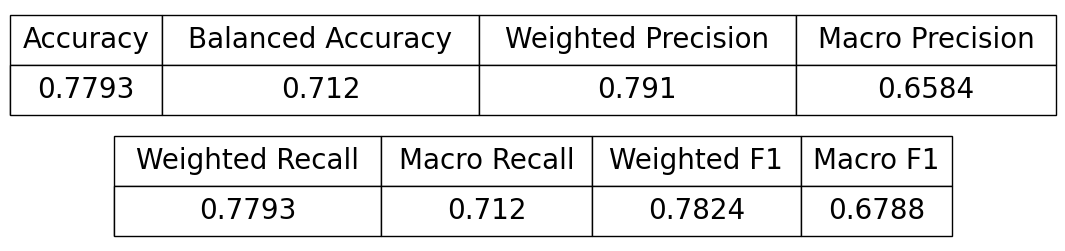

In [ ]:
evaluate_performance(y_true, y_pred, 'j2-grande')

Print confusion matrix

In [ ]:
cm = metrics.confusion_matrix(y_true, y_pred)
cm

array([[ 20,   1,   0,   0,   1,   0,   0,   0,   2,   4,   0,   1,   0,
          0,   0,   1],
       [  1,  78,   1,   4,   1,   1,   0,   0,   2,   9,   1,   3,   0,
          0,   0,   1],
       [  0,   1,  20,   1,   0,   0,   2,   0,   0,   0,   2,   0,   0,
          1,   0,   0],
       [  0,   6,   2,  76,   0,   0,   1,   1,   2,   4,   4,   5,   0,
          0,   0,   1],
       [  0,   0,   1,   1,   4,   1,   0,   0,   1,   0,   1,   0,   1,
          0,   0,   0],
       [  0,   0,   0,   2,   0,   4,   0,   0,   1,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   1,   0,   0,   0,   4,   0,   0,   0,   0,   1,   0,
          0,   0,   0],
       [  0,   0,   1,   0,   0,   0,   0,  10,   1,   0,   1,   0,   1,
          0,   0,   0],
       [  2,   3,   0,   2,   0,   0,   0,   2, 208,  21,  15,  12,   0,
          1,   2,   2],
       [  1,  13,   5,  10,   0,   1,   1,   1,  24, 510,  18,  27,   4,
          5,   3,   9],
       [  1,   1,   3,   3,   

Print classification report

In [ ]:
cr = metrics.classification_report(y_true, y_pred)
cr

'              precision    recall  f1-score   support\n\n           0       0.77      0.67      0.71        30\n           1       0.73      0.76      0.75       102\n           2       0.56      0.74      0.63        27\n           3       0.68      0.75      0.71       102\n           4       0.57      0.40      0.47        10\n           5       0.40      0.57      0.47         7\n           6       0.44      0.67      0.53         6\n           7       0.62      0.71      0.67        14\n           8       0.82      0.77      0.80       270\n           9       0.91      0.81      0.85       632\n          10       0.73      0.79      0.76       178\n          11       0.69      0.79      0.74       207\n          12       0.61      0.58      0.60        24\n          13       0.67      0.71      0.69        31\n          14       0.68      0.86      0.76        22\n          15       0.65      0.80      0.72        46\n\n    accuracy                           0.78      1708\n   ma